# RX Sensitivity Training

TODO:

X 1. Find meta model to handle missing input values
X    - Add filter to remove all null rows in train or test data in default train fn
X 2. Add matrix completion or MICE as imputation for Y_train
3. Add RPPA predictions to meta model inputs
4. Convert this to a script so that multiprocessing can be used?
X 5. Set up storage of predictions for different experiments so that progress can be documented well
6. Convert mutations back to amino acid change representation
X 7. Try TPOT as base learner

8. Add wrapper around multioutputregressor base estimators to remove records for null in response, rather than just using imputed version

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from mgds.data_modeling import data as feature_data
from py_utils import collection_utils

def plot_file(filename):
    path = '/Users/eczech/repos/mgds/python/notebook/data_modeling/rx_modeling/results'
    return os.path.join(path, filename)

2017-03-22 18:27:46,543:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
# entity_mappings={
#     entity.CELL_LINE: api.get_entity_mapping(entity.CELL_LINE),
#     entity.PRIMARY_SITE: api.get_entity_mapping(entity.PRIMARY_SITE)
# }
# df = api.get_raw_genomic_data(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, mappings=entity_mappings)
# df['INDICATOR'] = 1

In [3]:
# df.head()

In [4]:
# df[df['CELL_LINE_ID:MGDS'].isnull()]

In [5]:
#df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'VALUE']).size().value_counts()
#df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'INDICATOR']).size().value_counts()

In [6]:
# df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC']).size().value_counts()

In [7]:
datasets = api.get_genomic_data_availability()
datasets = [v for v in datasets if v[1] == dtyp.DRUG_SENSITIVITY]
datasets

[('gdsc_v2', 'drug-sensitivity'),
 ('ctd_v2', 'drug-sensitivity'),
 ('nci60_v2', 'drug-sensitivity'),
 ('ncidream_v1', 'drug-sensitivity')]

In [8]:
datasets = api.get_genomic_data_availability()
d = db.cache_prep_operation(lambda: feature_data.get_feature_datasets(datasets), 'raw-features', overwrite=False)

2017-03-22 18:27:49,429:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"


In [9]:
d.head()

ccle_v1                   \
                                         gene-copy-number                    
                                                     A1BG A1BG-AS1    A1CF   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM          -0.1544  -0.1544 -0.0985   
143B              BONE                            -0.2120  -0.2120  0.1580   
184A1             BREAST                              NaN      NaN     NaN   
184B5             BREAST                              NaN      NaN     NaN   
2004              NULL                                NaN      NaN     NaN   

                                                                          \
                                                                           
                                             A2M   A2ML1  A4GALT   A4GNT   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM -0.1819 -0.1819 -0.1732  0.2575   
143B              BONE                   -0.1753 -0.1753 -0.2536  0.2060   
184A1             BREAST                     NaN     NaN     NaN     NaN   
184B5             BREAST                     NaN     NaN     NaN     NaN   
2004              NULL                       NaN     NaN     NaN     NaN   

                                                                    ...     \
                                                                    ...      
                                            AAAS    AACS  AACSP1    ...      
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                 ...      
1321N1            CENTRAL_NERVOUS_SYSTEM -0.0404 -0.1284  0.1682    ...      
143B              BONE                   -0.1445 -0.2757  0.2150    ...      
184A1             BREAST                     NaN     NaN     NaN    ...      
184B5             BREAST                     NaN     NaN     NaN    ...      
2004              NULL                       NaN     NaN     NaN    ...      

                                              ncidream_v1                    \
                                         drug-sensitivity                     
                                                    MG132 MG132B NELFINAVIR   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
1321N1            CENTRAL_NERVOUS_SYSTEM              NaN    NaN        NaN   
143B              BONE                                NaN    NaN        NaN   
184A1             BREAST                         2.044571    NaN   1.700421   
184B5             BREAST                         2.052219    NaN   1.673305   
2004              NULL                                NaN    NaN        NaN   

                                                                            \
                                                                             
                                         NILONTINIB OLOMOUCINEII    PS1145   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM        NaN          NaN       NaN   
143B              BONE                          NaN          NaN       NaN   
184A1             BREAST                   1.308054     1.704059  1.001932   
184B5             BREAST                   1.308054     1.709954  1.001932   
2004              NULL                          NaN          NaN       NaN   

                                                                          \
                                                                           
                                               QNZ  TCSPIM11 TRASTUZUMAB   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM       NaN       NaN         NaN   
143B              BONE                         NaN       NaN         NaN   
184A1             BREAST                  1.499077  1.640310    1.718021   
184B5       

In [171]:
dt = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)]['NAVITOCLAX'].dropna().reset_index()
dt = dt[dt['PRIMARY_SITE:MGDS'] == 'BREAST']
(dt['NAVITOCLAX'] <= -1).value_counts()

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning:

indexing past lexsort depth may impact performance.



False    41
True      3
Name: NAVITOCLAX, dtype: int64

# Compute Aggregates

In [10]:
# Combine ccle and gdsc GE into one dataset

def gen_agg_data(d, src1, src2, data_type):
    d1 = d[(src1, data_type)]
    d2 = d[(src2, data_type)]

    shared_genes = list(np.intersect1d(d1.columns.tolist(), d2.columns.tolist()))
    
    def prep_scaling(df):
        dfv = df.stack()
        return (df - dfv.mean()) / dfv.std()
    d3 = (prep_scaling(d1[shared_genes]) + prep_scaling(d2[shared_genes]))/2
    return d3
    
d_agg_ge = gen_agg_data(d, src.CCLE_v1, src.GDSC_v2, dtyp.GENE_EXPRESSION)
d_agg_ge.columns = pd.MultiIndex.from_tuples([('agg', dtyp.GENE_EXPRESSION, c) for c in d_agg_ge])
d_agg_ge.head()

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.



agg                 \
                                         gene-expression                  
                                                    A1BG A1CF A2M A2ML1   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                       
1321N1            CENTRAL_NERVOUS_SYSTEM             NaN  NaN NaN   NaN   
143B              BONE                               NaN  NaN NaN   NaN   
184A1             BREAST                             NaN  NaN NaN   NaN   
184B5             BREAST                             NaN  NaN NaN   NaN   
2004              NULL                               NaN  NaN NaN   NaN   

                                                                               \
                                                                                
                                         A4GALT A4GNT AAAS AACS AADAC AADACL2   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                             
1321N1            CENTRAL_NERVOUS_SYSTEM    NaN   NaN  NaN  NaN   NaN     NaN   
143B              BONE                      NaN   NaN  NaN  NaN   NaN     NaN   
184A1             BREAST                    NaN   NaN  NaN  NaN   NaN     NaN   
184B5             BREAST                    NaN   NaN  NaN  NaN   NaN     NaN   
2004              NULL                      NaN   NaN  NaN  NaN   NaN     NaN   

                                         ...                                  \
                                         ...                                   
                                         ...  ZSWIM8 ZUFSP ZWILCH ZWINT ZXDC   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS      ...                                   
1321N1            CENTRAL_NERVOUS_SYSTEM ...     NaN   NaN    NaN   NaN  NaN   
143B              BONE                   ...     NaN   NaN    NaN   NaN  NaN   
184A1             BREAST                 ...     NaN   NaN    NaN   NaN  NaN   
184B5             BREAST                 ...     NaN   NaN    NaN   NaN  NaN   
2004              NULL                   ...     NaN   NaN    NaN   NaN  NaN   

                                                                       
                                                                       
                                         ZYG11A ZYG11B ZYX ZZEF1 ZZZ3  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                    
1321N1            CENTRAL_NERVOUS_SYSTEM    NaN    NaN NaN   NaN  NaN  
143B              BONE                      NaN    NaN NaN   NaN  NaN  
184A1             BREAST                    NaN    NaN NaN   NaN  NaN  
184B5             BREAST                    NaN    NaN NaN   NaN  NaN  
2004              NULL                      NaN    NaN NaN   NaN  NaN  

[5 rows x 14186 columns]

In [11]:
n_before = len(d)
d = pd.concat([d, d_agg_ge], axis=1)
assert len(d) == n_before
d.head()

ccle_v1                   \
                                         gene-copy-number                    
                                                     A1BG A1BG-AS1    A1CF   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM          -0.1544  -0.1544 -0.0985   
143B              BONE                            -0.2120  -0.2120  0.1580   
184A1             BREAST                              NaN      NaN     NaN   
184B5             BREAST                              NaN      NaN     NaN   
2004              NULL                                NaN      NaN     NaN   

                                                                          \
                                                                           
                                             A2M   A2ML1  A4GALT   A4GNT   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM -0.1819 -0.1819 -0.1732  0.2575   
143B              BONE                   -0.1753 -0.1753 -0.2536  0.2060   
184A1             BREAST                     NaN     NaN     NaN     NaN   
184B5             BREAST                     NaN     NaN     NaN     NaN   
2004              NULL                       NaN     NaN     NaN     NaN   

                                                                 ...   \
                                                                 ...    
                                            AAAS    AACS  AACSP1 ...    
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                              ...    
1321N1            CENTRAL_NERVOUS_SYSTEM -0.0404 -0.1284  0.1682 ...    
143B              BONE                   -0.1445 -0.2757  0.2150 ...    
184A1             BREAST                     NaN     NaN     NaN ...    
184B5             BREAST                     NaN     NaN     NaN ...    
2004              NULL                       NaN     NaN     NaN ...    

                                                     agg                     \
                                         gene-expression                      
                                                  ZSWIM8 ZUFSP ZWILCH ZWINT   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
1321N1            CENTRAL_NERVOUS_SYSTEM             NaN   NaN    NaN   NaN   
143B              BONE                               NaN   NaN    NaN   NaN   
184A1             BREAST                             NaN   NaN    NaN   NaN   
184B5             BREAST                             NaN   NaN    NaN   NaN   
2004              NULL                               NaN   NaN    NaN   NaN   

                                                                            
                                                                            
                                         ZXDC ZYG11A ZYG11B ZYX ZZEF1 ZZZ3  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                         
1321N1            CENTRAL_NERVOUS_SYSTEM  NaN    NaN    NaN NaN   NaN  NaN  
143B              BONE                    NaN    NaN    NaN NaN   NaN  NaN  
184A1             BREAST                  NaN    NaN    NaN NaN   NaN  NaN  
184B5             BREAST                  NaN    NaN    NaN NaN   NaN  NaN  
2004              NULL                    NaN    NaN    NaN NaN   NaN  NaN  

[5 rows x 253753 columns]

# Attach TCGA predictions here

In [12]:
from ml.api.trainer import TrainingResult
from ml.api.results import properties

In [13]:
# #path = dbm.file('rppa', 'cohorts/brca/rna_seq/multi_task/train_res')
# path = dbm.file('rppa', 'cohorts/brca/rna_seq/multi_task/train_res')
# train_res = TrainingResult.load(path)

In [14]:
from sklearn.preprocessing import StandardScaler
def get_rppa_predictions(dtyp_train, source_predict):
    path = dbm.file('rppa', 'cohorts/brca/{}/multi_task/train_res'.format(dtyp_train))
    train_res = TrainingResult.load(path)
    
    est = properties.extract_refit_model_map(train_res)['lasso']
    X_rppa = d[source_predict][dtyp.GENE_EXPRESSION][est.X_names].dropna(how='all', axis=0)
    assert np.all(X_rppa.notnull())
    Y_rppa = est.clf.predict(StandardScaler().fit_transform(X_rppa))
    cols = pd.MultiIndex.from_tuples([
        (src.TCGA_v1, 'rppa-{}-{}'.format(source_predict, dtyp_train), c) 
        for c in est.Y_names
    ])
    Y_rppa = pd.DataFrame(Y_rppa, columns=cols, index=X_rppa.index)
    assert np.all(Y_rppa.notnull())
    return Y_rppa

d = pd.concat([
    d, 
    get_rppa_predictions('gene_expression', 'agg')
#     get_rppa_predictions('gene_expression', src.CCLE_v1),
#     get_rppa_predictions('gene_expression', src.GDSC_v2)
], axis=1)

2017-03-22 18:28:12,056:DEBUG:py_utils.io_utils: Restoring serialized object "CV Training Result" from location "/Users/eczech/data/research/mgds/modeling/rppa/cohorts/brca/gene_expression/multi_task/train_res.pkl"


# Feature Analysis

In [15]:
def summarise_cols(name, cols):
    cts = pd.Series([':'.join(c[:2]) for c in cols]).value_counts()
    print('{}| Num column levels = {}, Group frequencies:\n{}'.format(name, cols.nlevels, cts))

summarise_cols('All training data', d.columns)

All training data| Num column levels = 3, Group frequencies:
ncidream_v1:gene-rna-seq            30154
ncidream_v1:gene-copy-number        27230
nci60_v2:gene-copy-number           23367
nci60_v2:gene-expression            22370
ccle_v1:gene-copy-number            20381
gdsc_v2:gene-exome-seq              19100
ncidream_v1:gene-expression         18632
gdsc_v2:gene-expression             17419
ccle_v1:gene-expression             16042
ncidream_v1:gene-methylation        14475
agg:gene-expression                 14186
ncidream_v1:gene-exome-seq          11995
nci60_v2:gene-exome-seq             11203
nci60_v2:drug-sensitivity            4210
ccle_v1:gene-exome-seq               2165
ctd_v2:drug-sensitivity               545
gdsc_v2:drug-sensitivity              251
tcga_v1:rppa-agg-gene_expression      169
ncidream_v1:drug-sensitivity           28
dtype: int64


In [16]:
sites = d.index.get_level_values('PRIMARY_SITE:MGDS')
sites.value_counts()

HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    244
LUNG                                  230
SKIN                                   88
BREAST                                 86
CENTRAL_NERVOUS_SYSTEM                 77
LARGE_INTESTINE                        68
OVARY                                  66
BONE                                   61
UPPER_AERODIGESTIVE_TRACT              60
NULL                                   54
KIDNEY                                 53
PANCREAS                               49
STOMACH                                48
AUTONOMIC_GANGLIA                      39
OESOPHAGUS                             37
URINARY_TRACT                          30
ENDOMETRIUM                            29
LIVER                                  29
SOFT_TISSUE                            28
PLEURA                                 26
THYROID                                18
CERVIX                                 14
BILIARY_TRACT                          12
PROSTATE                          

In [17]:
# cols = [v for v in api.get_genomic_data_availability() if v[1] == dtyp.DRUG_SENSITIVITY]
# cols

In [18]:
drugs = pd.Series([c[2] for c in d if c[1] == dtyp.DRUG_SENSITIVITY])
drugs.drop_duplicates().head()

0            17AAG
1    5FLUOROURACIL
2    5Z7OXOZEAENOL
3           681640
4          A443654
dtype: object

In [19]:
#test_drugs = ['NAVITOCLAX', 'NUTLIN3A']
test_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']
sorted([v for v in drugs if v in test_drugs])

['AG014699',
 'NAVITOCLAX',
 'NAVITOCLAX',
 'NUTLIN3A',
 'PD0332991',
 'PLX4720',
 'PLX4720',
 'SB590885']

In [20]:

# Test mode
# target_drugs = ['NAVITOCLAX', 'NUTLIN3A']
# target_genes = [
#     'A1BG', 'A1GB-AS1', 'A1CF', 'A2M', 'A2ML1',
#     'YAP1', 'WNK3', 'WHSC1L1', 'TNFRSF13B', 'PRKCB', 'PAX2', 'MNX1'
# ]

# Real targets
target_genes = None
target_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']
#target_drugs = ['NAVITOCLAX', 'VORINOSTAT', 'NILOTINIB']

# Navitoclax and 9 highly correlated
# target_drugs = [
#     'NAVITOCLAX', 'VORINOSTAT', 'VX702', 'NILOTINIB', 
#     'GSK1070916', 'GDC0449', 'NPK76II721', 'BX912',
#     'AICAR', 'TUBASTATINA'
# ]

# dt = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)]
# cts = dt.isnull().mean(axis=0).sort_values()
# len(cts[cts < .45])

# target_drugs = [
#     'CHLORAMBUCIL', 'FLUOROURACIL', 'CIMETIDINE', 'AZACITIDINE',
#     'TRIFLUOPERAZINE', 'PACLITAXEL', 'TAMOXIFEN', 'CARBOPLATIN',
#     'TENIPOSIDE', 'SILDENAFIL', 'SIMVASTATIN', 'PROCARBAZINE',
#     'CICLOPIROX', 'METHOTREXATE', 'LOVASTATIN', 'VALDECOXIB'
# ]
    
    
# target_drugs = [
#     'DACARBAZINE', 'PROCHLORPERAZINE', 'IFOSFAMIDE', 'DOXORUBICIN',
#     'TOPOTECAN', 'ETOPOSIDE', 'MITOMYCIN', 'TACROLIMUS'
# ]
    
# target_drugs = [
#     'DASATINIB', 'ERLOTINIB', 'CICLOSPORIN', 'RAPAMYCIN', 'SITAGLIPTIN',
#     'VINCRISTINE', 'CYTARABINE', 'ITRACONAZOLE', 'IMATINIB',
#     'DECITABINE', 'VANDETANIB', 'SORAFENIB', 'TEMOZOLOMIDE',
#     'BEXAROTENE', 'NILOTINIB', 'SUNITINIB', 'BENDAMUSTINE', 'PLATIN',
#     'BORTEZOMIB', 'GEMCITABINE', 'FULVESTRANT', 'REGORAFENIB',
#     'LENVATINIB', 'RUXOLITINIB', 'BLEOMYCIN', 'FINGOLIMOD', 'PAZOPANIB'
# ]
    
# target_drugs = [
#     'PLX4032', 'TIGECYCLINE', 'CLOFARABINE', 'FLUVASTATIN', 'BOSUTINIB',
#     'TEMSIROLIMUS', 'NELARABINE', 'ATRA', 'DEXAMETHASONE', 'CRIZOTINIB',
#     'LAPATINIB', 'XL184', 'CYCLOPHOSPHAMIDE', 'NICLOSAMIDE',
#     'GEFITINIB', 'VORINOSTAT', 'AXITINIB', 'OXALIPLATIN',
#     'OMACETAXINEMEPESUCCINATE', 'ABIRATERONE', 'THALIDOMIDE',
#     'DOCETAXEL'
# ]

#target_drugs += ['NAVITOCLAX']#, 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699', 'PD0332991']

target_drug_sources = [src.GDSC_v2, src.CTD_v2, src.NCI60_v2]


# target_drugs = ['Navitoclax', 'Nutlin', 'AG-014699', 'PD-0332991', 'PLX4720', 'SB590885']



In [21]:
dt = d[(src.CTD_v2, dtyp.DRUG_SENSITIVITY)]
np.setdiff1d(target_drugs, dt.columns.tolist())

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning:

indexing past lexsort depth may impact performance.



array(['AG014699', 'NUTLIN3A', 'PD0332991', 'SB590885'], 
      dtype='<U10')

In [22]:
dt = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)]
dt = dt[np.intersect1d(dt.columns.tolist(), target_drugs)]

dt = dt.apply(lambda v: (v.dropna() < .2).value_counts()).T
dt.columns = dt.columns.astype(str)
dt['Pct'] = dt['True'] / (dt['True'] + dt['False'])
dt.sort_values('Pct')

#cts = dt.isnull().mean(axis=0).sort_values()


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning:

indexing past lexsort depth may impact performance.



False  True       Pct
AG014699      938     3  0.003188
NUTLIN3A      862     5  0.005767
PLX4720       924    15  0.015974
SB590885      831    16  0.018890
PD0332991     697   146  0.173191
NAVITOCLAX    651   216  0.249135

In [23]:
#response_fields = [c for c in d if c[1] == dtyp.DRUG_SENSITIVITY]
import traceback
from ml.sklearn import feature_selection as ml_feature_selection
from ml.sklearn import transform as ml_transform
from ml.sklearn import multioutput as ml_multioutput

from ml.sklearn.baseline import AverageRegressor
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import MultiTaskLassoCV, MultiTaskElasticNetCV, ElasticNetCV, LassoCV, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from fancyimpute import MICE, NuclearNormMinimization, KNN, BiScaler
from py_utils import collection_utils
from mgds.data_modeling.constants import SEED

import pdb


imputer_zero = lambda X: np.nan_to_num(X)
imputer_mean = lambda X: Imputer(strategy='mean').fit_transform(X)
imputer_mice = lambda X: MICE(verbose=False).complete(np.array(X))
imputer_knn = lambda X: KNN(verbose=False, normalizer=BiScaler(verbose=False, center_rows=False, scale_rows=False)).complete(np.array(X))
imputer_nnorm = lambda X: NuclearNormMinimization(verbose=False).complete(np.array(X))
def_imputer = imputer_mice


def get_drug_sensitivity_selector(source):
    def selector(d):
        return [c for c in d if c[0] == source and c[1] == dtyp.DRUG_SENSITIVITY]
    return selector

def get_feature_selector(sources, data_types, names=None):
    if not isinstance(sources, list):
        sources = [sources]
    if not isinstance(data_types, list):
        data_types = [data_types]
        
    def selector(d):
        # summarize_cols('features', d.columns)
        feats = [c for c in d if c[0] in sources and c[1] in data_types]
        if names is None:
            return feats
        cols = [c for c in feats if c[2] in names]
        assert len(cols) > 0, \
            'Feature selector for sources "{}" and data types "{}" resulted in empty set'\
            .format(sources, data_types)
        return cols
    return selector

def get_rppa_selector(names=None):
    sources = [src.TCGA_v1]
    def selector(d):
        # summarize_cols('features', d.columns)
        feats = [c for c in d if c[0] in sources]
        if names is None:
            return feats
        cols = [c for c in feats if c[2] in names]
        assert len(cols) > 0, \
            'Feature selector for sources "{}" and data types "{}" resulted in empty set'\
            .format(sources, data_types)
        return cols
    return selector


def remove_null_rows(X, Y=None, msg=''):
    non_na_mask = X.notnull().any(axis=1)
    if non_na_mask.any():
        n_after = np.sum(non_na_mask)
        assert n_after > 0
        n_before = len(X)
        n_diff = n_before - n_after
        X = X[non_na_mask.values]
        if Y is not None:
            Y = Y[non_na_mask.values]
            assert len(X) == len(Y) == n_after
        else:
            assert len(X) == n_after
        if n_before != n_after:
            diff = n_before - n_after
            assert diff > 0
            pct = round(100 * diff / n_before, 2)
            #logger.info('Removed {} records of {} ({}%) due to null rows in {}'.format(diff, n_before, pct, msg))
    return X, Y

def remove_sparse_cols(d, name, min_present=15):
    mask = d.notnull().sum(axis=0).values < min_present
    if np.all(mask):
        logger.warning('All columns have less than {} values present in {}'.format(min_present, name))
        return None
    elif np.any(mask) > 0:
#         logger.info(
#             'Removing {} columns of {} from {} due to having less than {} non-null values'
#             .format(np.sum(mask), d.shape[1], name, min_present)
#         )
        return d[d.columns.values[~mask]]
    else:
        return d

    
def na_stats(d):
    n_na = d.isnull().sum().sum()
    n = d.shape[0] * d.shape[1]
    return n_na, n, round(100 * n_na / n, 2)
    
    
def impute_prep(d, imputer, name):
    n_na, n, pct = na_stats(d)
    if n_na > 0:
        logger.info('Imputation stats for {}: {} / {} ({}%) [shape = {}]'.format(name, n_na, n, pct, d.shape))
        d = pd.DataFrame(imputer(d), index=d.index, columns=d.columns)
        assert np.all(d.notnull())
    return d

    
def get_default_train_fn(est_factory, X_imputer=def_imputer, Y_imputer=None):
    def train(X_train, Y_train, X_test, prefit_est):
            
        if prefit_est is not None:
            est = prefit_est
        else:
            Y_train, X_train = remove_null_rows(Y_train, X_train, 'Y_train')
            X_train, Y_train = remove_null_rows(X_train, Y_train, 'X_train')
            Y_train = remove_sparse_cols(Y_train, 'Y_train')
            
            # If there was not a useful amount of data to fit on, return nothing
            if Y_train is None:
                return None, None

            if Y_imputer is not None:
                Y_train = impute_prep(Y_train, Y_imputer, 'Y_train')
            if X_imputer is not None:
                X_train = impute_prep(X_train, X_imputer, 'X_train')
            assert np.all(X_train.notnull())
            assert np.all(np.isfinite(X_train))
                
            est = est_factory()
            #logger.info('Running estimator on X_train.shape = {}, Y_train.shape = {}'.format(X_train.shape, Y_train.shape))
            #logger.info('Y non-null counts: {}'.format(Y_train.notnull().sum(axis=0).min()))
            try:
                est = est.fit(X_train.values, Y_train.values)
            except:
                print(traceback.format_exc())
                pdb.set_trace()
            
        Y_pred = None
        if X_test is not None: 
            X_test, _ = remove_null_rows(X_test, None, 'X_test')
            if X_imputer is not None:
                X_test = impute_prep(X_test, X_imputer, 'X_test')
            assert np.all(X_test.notnull())
            assert np.all(np.isfinite(X_test))
            Y_pred = pd.DataFrame(est.predict(X_test.values), index=X_test.index, columns=Y_train.columns)

        return est, Y_pred
    return train


def get_imputer_transform(X_imputer, Y_imputer):
    def transform(X, Y):
        if Y_imputer is None:
            assert Y.ndim == 1
            mask = ~np.isnan(Y)
            X, Y = X[mask], Y[mask]
        else:
            Y = Y_imputer(Y)
            
        if X_imputer is not None:
            X = X_imputer(X)
        return X, Y
            
    return transform


def Y_dropper(X, y):
    assert y.ndim == 1
    mask = ~np.isnan(y)
    X, y = X[mask], y[mask]
    assert len(y) > 0
    assert np.all(np.isfinite(X))
    assert np.all(np.isfinite(y))
    return X, y

from sklearn.multioutput import MultiOutputRegressor

def regressor_factory(estimator_factory, mode=None, discrete=False, k=500, scale=True, select=True):
    def create_pipeline():
        steps = []
        steps += [('nzv', VarianceThreshold())]
        if scale:
            steps += [('scale', StandardScaler())]
            
        if select:
            # TODO: Modify this to also support discrete features; f_regression is ok for continuous
            # and ordered categorical/binary but less so for unordered categorical (so maybe that's ok?)
            
            selector = ml_feature_selection.SelectAtMostKBest(f_regression, k=k, validate=False)
            selector = ml_transform.TransformEstimator(estimator=selector, transformer=Y_dropper)
            steps.append(('select', ml_feature_selection.MultiOutputSelect(selector=selector, strategy='any')))
            
        est = estimator_factory()
        
        if mode == 'single_task_dropna':
            est = ml_transform.TransformEstimator(estimator=est, transformer=Y_dropper)
            est = ml_multioutput.MultiRegressor(est)
        elif mode == 'single_task':
            est = MultiOutputRegressor(est)
        elif mode != 'multi_task':
            raise ValueError('Mode "{}" not valid'.format(mode))
                
        steps += [('est', est)]
        return Pipeline(steps)
    return create_pipeline


#ALPHAS = [.01, .05, .1, .5, 1, 5]
ALPHAS = [1., .5, .25, .1, .08, .06]

def mt_lasso(**kwargs):
    return regressor_factory(
        lambda: MultiTaskLassoCV(random_state=SEED, alphas=ALPHAS), 
        mode='multi_task', **kwargs
    )

def std_lasso(**kwargs):
    return regressor_factory(
        lambda: LassoCV(random_state=SEED, alphas=ALPHAS), 
        mode='single_task_dropna', **kwargs
    )


def st_lasso(**kwargs):
    return regressor_factory(
        lambda: LassoCV(random_state=SEED, alphas=ALPHAS), 
        mode='single_task', **kwargs
    )

def mt_enet(**kwargs):
    return regressor_factory(
        lambda: MultiTaskElasticNetCV(random_state=SEED, l1_ratio=.5, alphas=ALPHAS), 
        mode='multi_task', **kwargs
    )

# def st_enet_regressor_factory(**kwargs):
#     return reg_factory(
#         lambda: ElasticNetCV(random_state=SEED, l1_ratio=.5, alphas=ALPHAS), 
#         **kwargs
#     )

def st_svr(**kwargs):
    return regressor_factory(
        lambda: GridSearchCV(SVR(), {'C': [.1, 1, 10, 25, 50, 100]}, cv=3), 
        mode='single_task', **kwargs
    )

def std_svr(**kwargs):
    return regressor_factory(
        lambda: GridSearchCV(SVR(), {'C': [.1, 1, 10, 25, 50, 100]}, cv=3), 
        mode='single_task_dropna', **kwargs
    )

def mt_rf(**kwargs):
    return regressor_factory(
        lambda: RandomForestRegressor(random_state=SEED), 
        mode='multi_task', **kwargs
    )

def std_rf(**kwargs):
    return regressor_factory(
        lambda: RandomForestRegressor(random_state=SEED), 
        mode='single_task_dropna', **kwargs
    )

def mt_etr(**kwargs):
    return regressor_factory(
        lambda: ExtraTreesRegressor(random_state=SEED), 
        mode='multi_task', **kwargs
    )

def std_etr(**kwargs):
    return regressor_factory(
        lambda: ExtraTreesRegressor(random_state=SEED),
        mode='single_task_dropna', **kwargs
    )

def std_poslasso(**kwargs):
    return regressor_factory(
        lambda: LassoCV(random_state=SEED, positive=True), 
        mode='single_task_dropna', **kwargs
    )

def std_avg(**kwargs):
    return regressor_factory(
        lambda: AverageRegressor(),
        mode='single_task_dropna', **kwargs
    )

Using TensorFlow backend.


In [24]:
common_estimators = {
    'response_selector': get_feature_selector(target_drug_sources, dtyp.DRUG_SENSITIVITY, target_drugs),
    'estimators': {
        
        # CCLE Gene Expression
        'st_svr500_agg_ge': {
            'feature_selector': get_feature_selector('agg', dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(st_svr(k=500), X_imputer=imputer_mean, Y_imputer=def_imputer)
        },
        'std_svr500_agg_ge': {
            'feature_selector': get_feature_selector('agg', dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_svr(k=500), X_imputer=imputer_mean, Y_imputer=None)
        },
        'std_lasso_agg_ge': {
            'feature_selector': get_feature_selector('agg', dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_lasso(), X_imputer=imputer_mean, Y_imputer=None)
        },
        'std_etr_agg_ge': {
            'feature_selector': get_feature_selector('agg', dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(std_etr(), X_imputer=imputer_mean, Y_imputer=None)
        },
        
        
        # RPPA
        'std_lasso_tcga_rppa': {
            'feature_selector': get_rppa_selector(),
            'train': get_default_train_fn(std_lasso(), X_imputer=imputer_mice, Y_imputer=None)
        },
        'std_svr500_tcga_rppa': {
            'feature_selector': get_rppa_selector(),
            'train': get_default_train_fn(std_svr(k=500), X_imputer=imputer_mice, Y_imputer=None)
        },
        'std_etr_tcga_rppa': {
            'feature_selector': get_rppa_selector(),
            'train': get_default_train_fn(std_etr(), X_imputer=imputer_mice, Y_imputer=None)
        },
        
    }
}

pan_site_estimators = {}
pan_site_estimators['response_selector'] = common_estimators['response_selector']
pan_site_estimators['estimators'] = {'pans_' + k: v for k, v in common_estimators['estimators'].items()}

per_site_estimators = {}
per_site_estimators['response_selector'] = common_estimators['response_selector']
per_site_estimators['estimators'] = {'pers_' + k: v for k, v in common_estimators['estimators'].items()}
# per_site_estimators['estimators'].update({
    
#         # CCLE Mutations
#         'pers_std_lasso_ccle_mu': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXOME_SEQ, target_genes),
#             'train': get_default_train_fn(std_lasso(discrete=True, scale=False), X_imputer=imputer_zero, Y_imputer=None)
#         },
    
#         # GDSC Mutations
#         'pers_st_lasso_gdsc_mu': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXOME_SEQ, target_genes),
#             'train': get_default_train_fn(st_lasso(discrete=True, scale=False), X_imputer=imputer_zero, Y_imputer=def_imputer)
#         }
# })

meta_response_selector = lambda d: [c for c in d if c[3] == 'Actual']
meta_feature_selector = lambda d: [c for c in d if not c[3] in ['Actual'] and not c[3].startswith('meta')]
meta_estimators = {
    'response_selector': meta_response_selector,
    'estimators': {
        'meta_std_rf': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_rf(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        },
        'meta_std_poslasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_poslasso(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        },
        'meta_std_lasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_lasso(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        },
        'meta_std_avg': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(std_avg(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
        }
        
    }
}


In [25]:


# common_estimators = {
#     'response_selector': get_feature_selector(target_drug_sources, dtyp.DRUG_SENSITIVITY, target_drugs),
#     'estimators': {
        
#         # CCLE Gene Expression
#        'mt_enet_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(mt_enet(), X_imputer=imputer_mean, Y_imputer=def_imputer)
#         },
#         'st_svr500_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(st_svr(k=500), X_imputer=imputer_mean, Y_imputer=def_imputer)
#         },
#         'std_svr500_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_svr(k=500), X_imputer=imputer_mean, Y_imputer=None)
#         },
#         'std_lasso_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_lasso(), X_imputer=imputer_mean, Y_imputer=None)
#         },
#         'std_etr_ccle_ge': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_etr(), X_imputer=imputer_mean, Y_imputer=None)
#         },
        
#         # GDSC Gene Expression
#         'mt_enet_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(mt_enet(), X_imputer=imputer_mean, Y_imputer=def_imputer)
#         },
#         'st_svr500_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(st_svr(k=500), X_imputer=imputer_mean, Y_imputer=def_imputer)
#         },
#         'std_svr500_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_svr(k=500), X_imputer=imputer_mean, Y_imputer=None)
#         },
# #         'std_svr2000_gdsc_ge': {
# #             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
# #             'train': get_default_train_fn(std_svr(k=2000), X_imputer=imputer_mean, Y_imputer=None)
# #         },
#         'std_lasso_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_lasso(), X_imputer=imputer_mean, Y_imputer=None)
#         },
#         'std_etr_gdsc_ge': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
#             'train': get_default_train_fn(std_etr(), X_imputer=imputer_mean, Y_imputer=None)
#         },
        
#         # RPPA
#         'std_lasso_tcga_rppa': {
#             'feature_selector': get_rppa_selector(),
#             'train': get_default_train_fn(std_lasso(), X_imputer=imputer_mice, Y_imputer=None)
#         },
#         'std_svr500_tcga_rppa': {
#             'feature_selector': get_rppa_selector(),
#             'train': get_default_train_fn(std_svr(k=500), X_imputer=imputer_mice, Y_imputer=None)
#         },
#         'std_etr_tcga_rppa': {
#             'feature_selector': get_rppa_selector(),
#             'train': get_default_train_fn(std_etr(), X_imputer=imputer_mice, Y_imputer=None)
#         },
        
#     }
# }

# pan_site_estimators = {}
# pan_site_estimators['response_selector'] = common_estimators['response_selector']
# pan_site_estimators['estimators'] = {'pans_' + k: v for k, v in common_estimators['estimators'].items()}

# per_site_estimators = {}
# per_site_estimators['response_selector'] = common_estimators['response_selector']
# per_site_estimators['estimators'] = {'pers_' + k: v for k, v in common_estimators['estimators'].items()}
# per_site_estimators['estimators'].update({
    
#         # CCLE Mutations
#         'pers_std_lasso_ccle_mu': {
#             'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXOME_SEQ, target_genes),
#             'train': get_default_train_fn(std_lasso(discrete=True, scale=False), X_imputer=imputer_zero, Y_imputer=None)
#         },
    
#         # GDSC Mutations
#         'pers_st_lasso_gdsc_mu': {
#             'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXOME_SEQ, target_genes),
#             'train': get_default_train_fn(st_lasso(discrete=True, scale=False), X_imputer=imputer_zero, Y_imputer=def_imputer)
#         }
# })

# meta_response_selector = lambda d: [c for c in d if c[3] == 'Actual']
# meta_feature_selector = lambda d: [c for c in d if not c[3] in ['Actual'] and not c[3].startswith('meta')]
# meta_estimators = {
#     'response_selector': meta_response_selector,
#     'estimators': {
#         'meta_std_rf': {
#             'feature_selector': meta_feature_selector,
#             'train': get_default_train_fn(std_rf(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
#         },
#         'meta_std_poslasso': {
#             'feature_selector': meta_feature_selector,
#             'train': get_default_train_fn(std_poslasso(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
#         },
#         'meta_std_lasso': {
#             'feature_selector': meta_feature_selector,
#             'train': get_default_train_fn(std_lasso(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
#         },
#         'meta_std_avg': {
#             'feature_selector': meta_feature_selector,
#             'train': get_default_train_fn(std_avg(select=False, scale=False), X_imputer=def_imputer, Y_imputer=None)
#         }
        
#     }
# }


In [17]:
#zero_imputer_factory().fit_transform(d[(src.CCLE_v1, dtyp.GENE_EXOME_SEQ)]).shape

In [144]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [26]:
def get_relevant_training_data(d):
    response_selectors = []
    response_selectors.append(per_site_estimators['response_selector'])
    response_selectors.append(pan_site_estimators['response_selector'])

    feature_selectors = []
    for estimator in per_site_estimators['estimators'].values():
        feature_selectors.append(estimator['feature_selector'])
    for estimator in pan_site_estimators['estimators'].values():
        feature_selectors.append(estimator['feature_selector'])

    return rx_train.restrict_training_data(d, feature_selectors, response_selectors)

d_train, cX, cY = get_relevant_training_data(d)
summarise_cols('Restricted training data', d_train.columns)

[Remove rows with all null features OR all null responses] Records before = 1473, Records after = 618, Records removed = 855 (%58.04)
Restricted training data| Num column levels = 3, Group frequencies:
agg:gene-expression                 14186
tcga_v1:rppa-agg-gene_expression      169
gdsc_v2:drug-sensitivity                6
ctd_v2:drug-sensitivity                 2
dtype: int64


In [27]:
#d_train.filter(regex='expression').info()

In [28]:
d_train[cY].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 618 entries, (22RV1, PROSTATE) to (ZR7530, BREAST)
Data columns (total 8 columns):
(gdsc_v2, drug-sensitivity, NAVITOCLAX)    529 non-null float64
(ctd_v2, drug-sensitivity, NAVITOCLAX)     524 non-null float64
(gdsc_v2, drug-sensitivity, PD0332991)     510 non-null float64
(gdsc_v2, drug-sensitivity, PLX4720)       584 non-null float64
(ctd_v2, drug-sensitivity, PLX4720)        517 non-null float64
(gdsc_v2, drug-sensitivity, NUTLIN3A)      529 non-null float64
(gdsc_v2, drug-sensitivity, AG014699)      583 non-null float64
(gdsc_v2, drug-sensitivity, SB590885)      516 non-null float64
dtypes: float64(8)
memory usage: 52.3+ KB


In [29]:
d_train[cY].describe()

gdsc_v2           ctd_v2          gdsc_v2              \
      drug-sensitivity drug-sensitivity drug-sensitivity               
            NAVITOCLAX       NAVITOCLAX        PD0332991     PLX4720   
count       529.000000       524.000000       510.000000  584.000000   
mean          1.317693        13.010964         1.760690    3.986570   
std           1.866402         2.333352         1.586230    1.205553   
min          -5.173815         4.035700        -2.800673   -1.621119   
25%           0.412144        12.184500         0.584139    3.362399   
50%           1.734678        13.698500         1.724098    4.193196   
75%           2.737977        14.576750         2.989156    4.844545   
max           4.403234        18.182000         5.715862    6.779484   

                ctd_v2          gdsc_v2                          
      drug-sensitivity drug-sensitivity                          
               PLX4720         NUTLIN3A    AG014699    SB590885  
count       517.000000       529.000000  583.000000  516.000000  
mean         14.529307         3.575810    3.449836    3.590355  
std           1.282004         1.347408    0.970235    1.219688  
min           9.049000        -0.782898   -0.371196   -2.764400  
25%          14.074000         2.740690    2.786846    3.101191  
50%          14.515000         3.902638    3.546240    3.822141  
75%          14.944000         4.594924    4.143923    4.404886  
max          18.712000         6.475514    6.005510    6.333998

In [30]:
Y_stratify = (
    pd.qcut(d_train[cY].apply(lambda v: (v - v.mean()) / v.std()).min(axis=1), q=[0., 1/3., 2/3., 1.])
    .astype(str)
)
Y_stratify.value_counts()

[-5.21, -1.478]     206
(-0.708, 1.635]     206
(-1.478, -0.708]    206
dtype: int64

In [149]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [125]:
#d_tr_before.equals(d_train)

True

In [31]:
%pdb on
site = 'BREAST'
cv_sites = [site]
cv = rx_train.get_cv_folds(d_train, Y_stratify, sites=cv_sites, random_state=SEED)
res = rx_train.run_training(d_train, cv, pan_site_estimators, per_site_estimators, meta_estimators)
%pdb off

2017-03-22 18:29:00,432:INFO:mgds.data_modeling.training01: Training pan site refit models across all sites ...
2017-03-22 18:29:00,440:INFO:mgds.data_modeling.training01: Training estimator "pans_std_etr_tcga_rppa" (X.shape = (618, 169), X NA 0.0, Y.shape = (618, 8), Y NA = 13.19, Y_test.shape = None)


Automatic pdb calling has been turned ON


2017-03-22 18:29:02,025:INFO:mgds.data_modeling.training01: Training estimator "pans_std_svr500_agg_ge" (X.shape = (618, 14186), X NA 0.0, Y.shape = (618, 8), Y NA = 13.19, Y_test.shape = None)
2017-03-22 18:30:48,475:INFO:mgds.data_modeling.training01: Training estimator "pans_std_etr_agg_ge" (X.shape = (618, 14186), X NA 0.0, Y.shape = (618, 8), Y NA = 13.19, Y_test.shape = None)
2017-03-22 18:31:08,869:INFO:mgds.data_modeling.training01: Training estimator "pans_st_svr500_agg_ge" (X.shape = (618, 14186), X NA 0.0, Y.shape = (618, 8), Y NA = 13.19, Y_test.shape = None)
2017-03-22 18:31:09,054:INFO:root: Imputation stats for Y_train: 652 / 4944 (13.19%) [shape = (618, 8)]
2017-03-22 18:33:25,631:INFO:mgds.data_modeling.training01: Training estimator "pans_std_svr500_tcga_rppa" (X.shape = (618, 169), X NA 0.0, Y.shape = (618, 8), Y NA = 13.19, Y_test.shape = None)
2017-03-22 18:33:34,531:INFO:mgds.data_modeling.training01: Training estimator "pans_std_lasso_tcga_rppa" (X.shape = (618, 

Automatic pdb calling has been turned OFF


In [32]:
version = 'v9'
notes = """
- 500 selected features
- Breast only
- Drug sensitivity from multiple sources
- Stratified CV
- Multiple imputation
"""

description = rx_train.get_result_description(notes)
rx_train.save_training_results({'cv': cv, 'res': res}, 'multi_source', version, description)

2017-03-22 19:20:35,921:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/multi_source/v9/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/multi_source/v9'

## Quick Analysis

Any real, in-depth analysis should be in a separate notebook

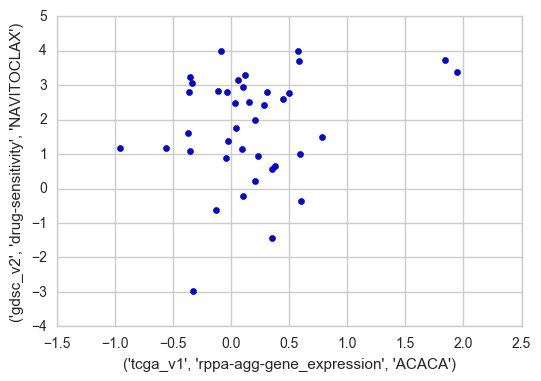

In [189]:
# One Gene vs One Drug

# c_var = (src.CCLE_v1, dtyp.GENE_EXPRESSION, 'BRAF')
# c_drug = (src.GDSC_v2, dtyp.DRUG_SENSITIVITY, 'PLX4720')

#c_var = ('agg', dtyp.GENE_EXPRESSION, 'BCL2')
#c_var = (src.TCGA_v1, 'rppa-agg-gene_expression', 'BCL2')
c_var = (src.TCGA_v1, 'rppa-agg-gene_expression', 'ACACA')
c_drug = (src.GDSC_v2, dtyp.DRUG_SENSITIVITY, 'NAVITOCLAX')

x, y = d[c_var], d[c_drug]
mask = d.reset_index()['PRIMARY_SITE:MGDS'] == 'BREAST'
x, y = x[mask.values], y[mask.values]
plt.scatter(x, y)
plt.xlabel(c_var)
plt.ylabel(c_drug)

In [174]:
est = res[site]['models']['pan_site']['pans_std_lasso_tcga_rppa']
#est = res[site]['models']['pan_site']['pans_std_lasso_agg_ge']
#est = res[site]['models']['per_site']['pers_std_lasso_agg_ge']
#est = res[site]['models']['per_site']['pers_std_lasso_tcga_rppa']

In [175]:
genes = [c[2] for c in est.input_fields.values]
drugs = [c[0]+'-'+c[2] for c in est.output_fields.values]
select = est.named_steps['select']
assert len(select.get_support()) == len(genes)
genes = np.array(genes)[select.get_support()]
drug_ests = est.named_steps['est'].estimators_

In [176]:
drugs

['gdsc_v2-NAVITOCLAX',
 'ctd_v2-NAVITOCLAX',
 'gdsc_v2-PD0332991',
 'gdsc_v2-PLX4720',
 'ctd_v2-PLX4720',
 'gdsc_v2-NUTLIN3A',
 'gdsc_v2-AG014699',
 'gdsc_v2-SB590885']

In [177]:
drug = 'gdsc_v2-NAVITOCLAX'
idx = drugs.index(drug)
g = pd.Series(drug_ests[idx].estimator.coef_, index=genes)
g = pd.concat([g, g.abs()], axis=1)
g.columns = ['value', 'abs']
g['rank'] = g['abs'].rank()
g.sort_values('abs', ascending=False).head(10)

value       abs   rank
BCL2   -0.343619  0.343619  169.0
ACACA   0.192879  0.192879  168.0
ETS1   -0.163023  0.163023  167.0
STK11  -0.163015  0.163015  166.0
ASNS    0.151505  0.151505  165.0
PXN     0.149185  0.149185  164.0
MAPK14  0.130304  0.130304  163.0
EIF4G1 -0.130290  0.130290  162.0
CDK1   -0.128442  0.128442  161.0
EEF2K  -0.128234  0.128234  160.0

In [178]:
g.filter(regex='TP53', axis=0)

value       abs   rank
TP53BP1  0.114489  0.114489  159.0
TP53    -0.000000  0.000000   61.5

In [179]:
g.filter(regex='BRAF', axis=0)

value       abs   rank
BRAF -0.004045  0.004045  125.0

In [180]:
g.filter(regex='RB1', axis=0)

value  abs  rank
RB1    0.0  0.0  61.5

In [66]:
d_pred = res[site]['prediction_data']
d_pred.head()

ctd_v2  \
                                                  drug-sensitivity   
                                                       SIMVASTATIN   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                    14.709046   
BT20              BREAST            1                    14.060598   
BT474             BREAST            1                    13.965242   
CAL51             BREAST            1                    13.922253   
EFM192A           BREAST            1                    13.780218   

                                                           gdsc_v2  \
                                                  drug-sensitivity   
                                                      METHOTREXATE   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                     1.041453   
BT20              BREAST            1                     1.041453   
BT474             BREAST            1                     1.041453   
CAL51             BREAST            1                     1.041453   
EFM192A           BREAST            1                     1.041453   

                                                            ctd_v2  \
                                                  drug-sensitivity   
                                                       AZACITIDINE   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                     14.45856   
BT20              BREAST            1                     14.45856   
BT474             BREAST            1                     14.45856   
CAL51             BREAST            1                     14.45856   
EFM192A           BREAST            1                     14.45856   

                                                                    \
                                                                     
                                                        LOVASTATIN   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                    12.196975   
BT20              BREAST            1                    14.028849   
BT474             BREAST            1                    11.413926   
CAL51             BREAST            1                    13.645794   
EFM192A           BREAST            1                    13.532568   

                                                                    \
                                                                     
                                                      PROCARBAZINE   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                    15.354491   
BT20              BREAST            1                    15.354491   
BT474             BREAST            1                    15.177985   
CAL51             BREAST            1                    15.430866   
EFM192A           BREAST            1                    15.430866   

                                                                    \
                                                                     
                                                        NAVITOCLAX   
                                            pers_std_lasso_ccle_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
AU565             BREAST            1                     13.37795   
BT20              BREAST            1                     13.37795   
BT474             BREAST            1                     13.3779

In [67]:
d_pred.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 55 entries, (AU565, BREAST, 1) to (ZR751, BREAST, 5)
Columns: 640 entries, (ctd_v2, drug-sensitivity, SIMVASTATIN, pers_std_lasso_ccle_mu) to (nci60_v2, drug-sensitivity, TENIPOSIDE, Actual)
dtypes: float64(640)
memory usage: 275.8+ KB


## Prediction EDA

In [105]:
# dtx = dt[[
#     (src.GDSC_v2, dtyp.DRUG_SENSITIVITY, 'NAVITOCLAX', 'pers_std_lasso_gdsc_ge'),
#     (src.GDSC_v2, dtyp.DRUG_SENSITIVITY, 'NAVITOCLAX', 'Actual')
# ]].sort_index().dropna().sort_index()
# dtx

In [62]:
dt.index.get_level_values('FOLD_ID').value_counts()

2    12
1    12
3    11
5    10
4    10
Name: FOLD_ID, dtype: int64

In [64]:
 #d_train[(src.CCLE_v1, dtyp.GENE_EXPRESSION, 'YAP1')].isnull().value_counts()

In [40]:
# dt[[
#     ('gdsc_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_rf_ccle_cn'),
#     ('gdsc_v2', 'drug-sensitivity', 'NUTLIN3A', 'pers_rf_ccle_cn'),
# ]].head()

In [67]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

# Performance

In [34]:
def plot_scores(d_score, rm_models=None, filename=None):
    if rm_models is not None:
        d_score = d_score[~d_score['MODEL_NAME'].isin(rm_models)]
        
    grps = d_score.groupby('DRUG')
    drugs=list(grps.groups.keys())
    fig = plty.tools.make_subplots(rows=grps.ngroups, cols=1, print_grid=False, subplot_titles=drugs)
    fig['layout'].update(height=500*len(drugs))
    
    for i, drug in enumerate(drugs):
        g1 = grps.get_group(drug)
        for metric, g2 in g1.groupby('METRIC'):
            trace = go.Box(x=g2['MODEL_NAME'], y=g2['VALUE'], boxmean='sd', name=metric)
            fig.append_trace(trace, i+1, 1)
    plty.offline.iplt(fig)
    if filename is not None:
        print(plty.offline.plt(fig, filename=filename))

In [191]:
from sklearn.metrics import r2_score, mean_squared_error
d_pred = res[site]['prediction_data']
score_functions = {
    #'r2': lambda y_true, y_pred: r2_score(y_true, y_pred) if len(y_true) > 0 else -1,
    #'corr': lambda y_true, y_pred: y_pred.corr(y_true),
    #'n': lambda y_true, y_pred: len(y_true),
    'spearman': lambda y_true, y_pred: y_pred.corr(y_true, method='spearman'),
    #'mse': lambda y_true, y_pred: mean_squared_error(y_true, y_pred)
}
d_score = rx_train.get_scores(d_pred, score_functions)
#plot_scores(d_score, rm_models=['meta_std_avg'])#, figaspect=12)
plot_scores(d_score, filename=plot_file('v2_perf_spearman.html'))

/Users/eczech/repos/mgds/python/notebook/data_modeling/rx_modeling/results/v2_perf_spearman.html


In [72]:
# d_pred.columns.tolist()

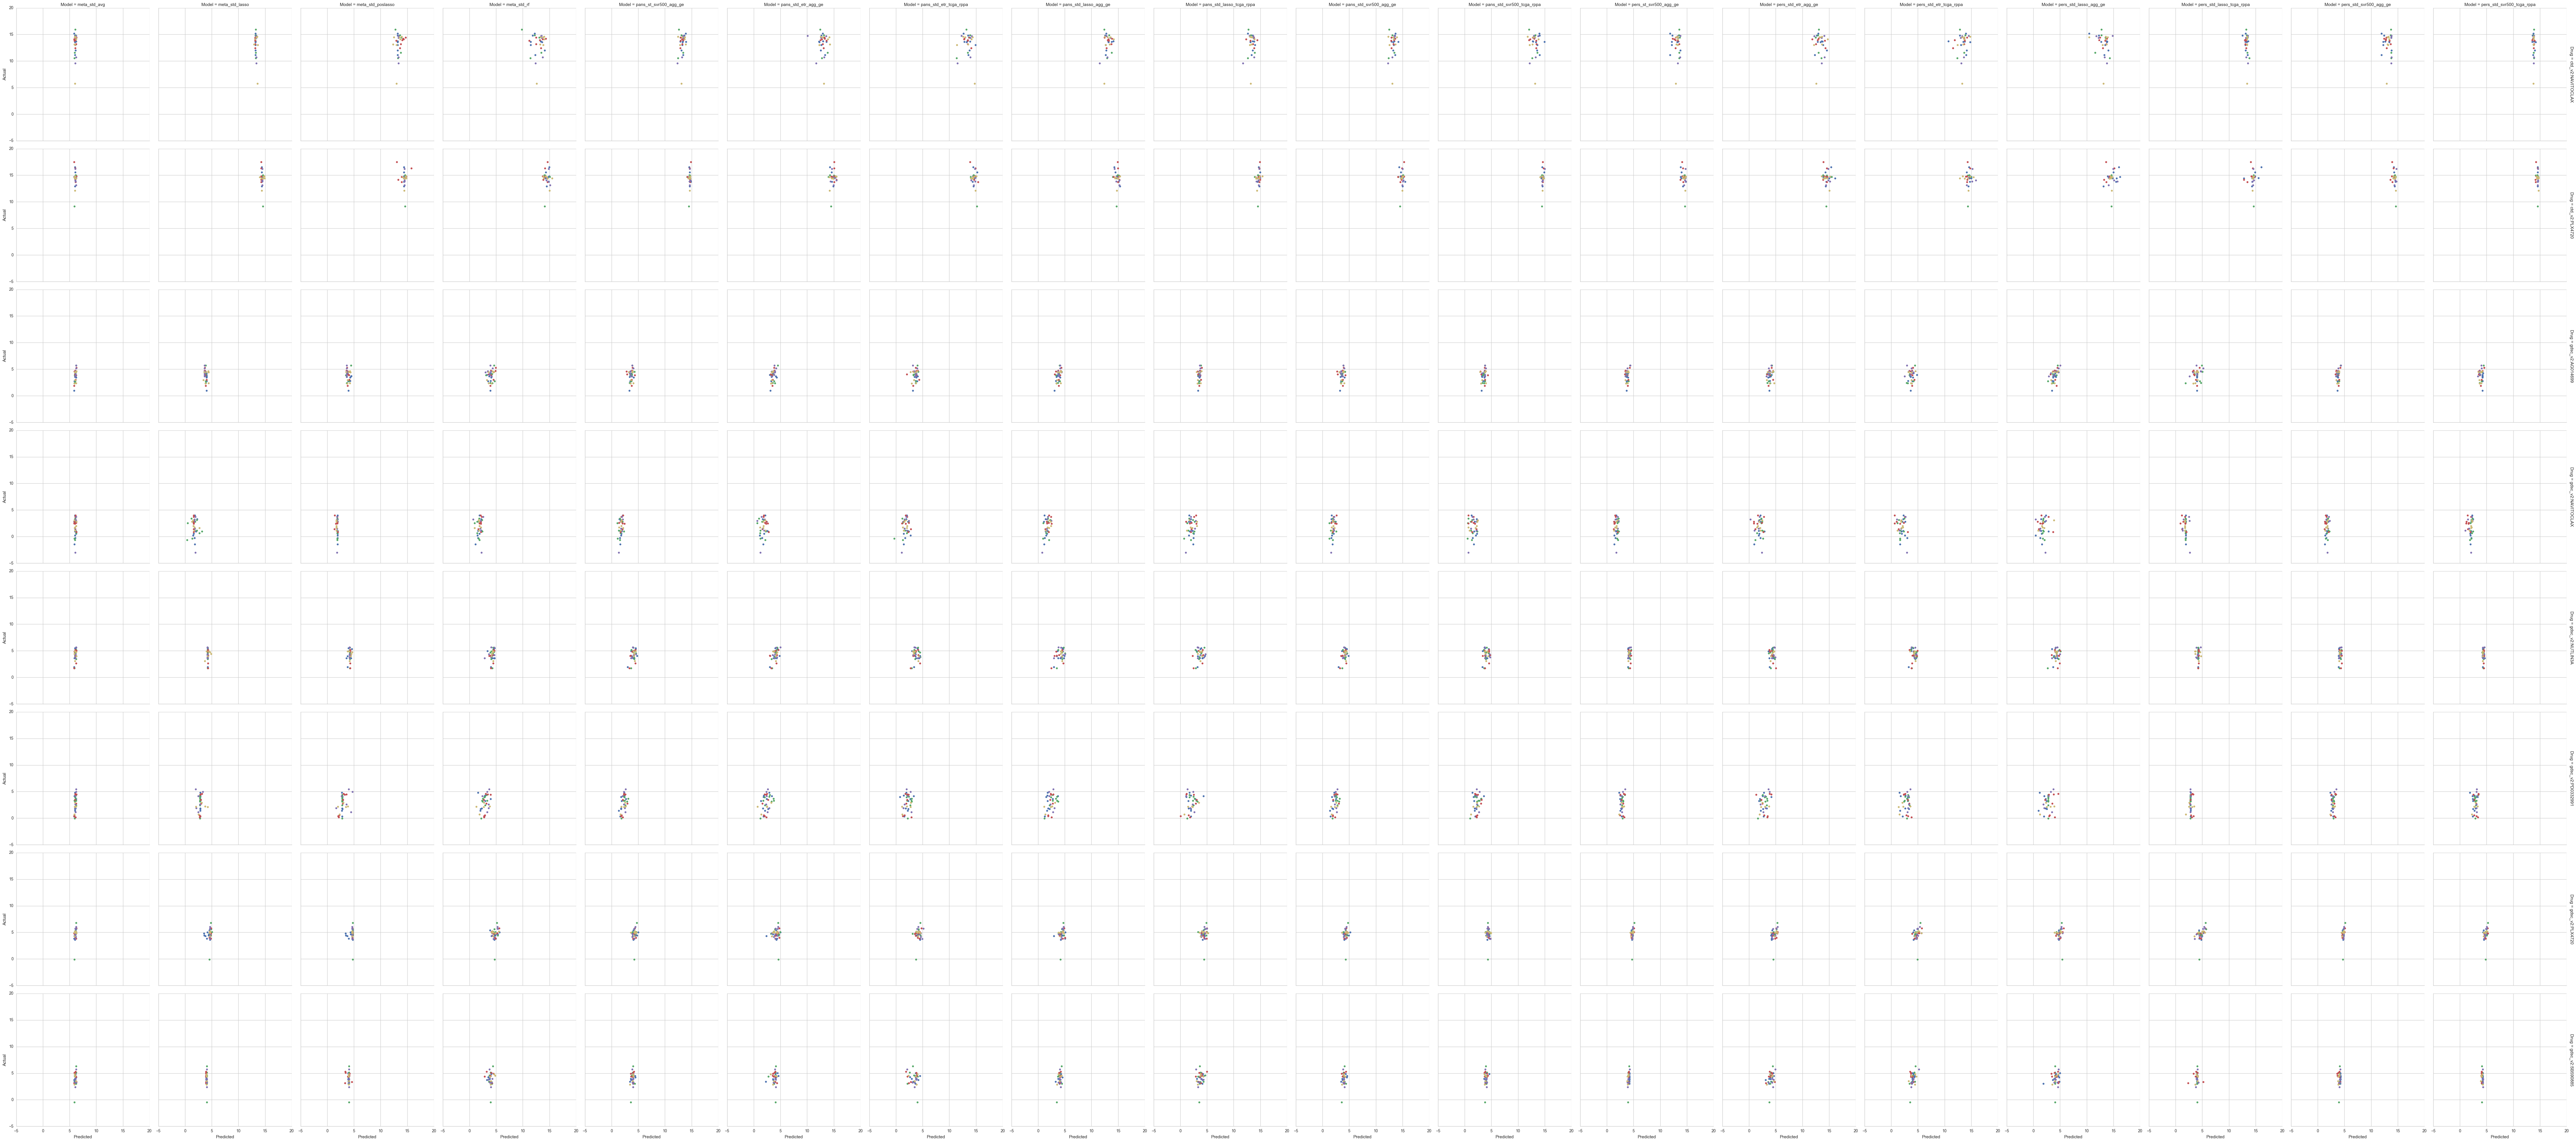

In [40]:
def plot_predictions(d_pred, share_axes=False):
    c_actual = [c for c in d_pred if c[-1] == 'Actual']
    c_pred = d_pred.columns.difference(c_actual)
    
    d = []
    for c_act in c_actual:
        drug_name = c_act[0] + ':' + c_act[-2]
        c_drug_pred = [c for c in c_pred if c[-2] == c_act[-2] and c[0] == c_act[0]]
        for c_pre in c_drug_pred:
            model_name = c_pre[-1]
            d.append(pd.DataFrame({
                'Predicted': d_pred[c_pre],
                'Actual': d_pred[c_act],
                'Drug': drug_name,
                'Model': model_name,
                'Fold': d_pred.index.get_level_values('FOLD_ID')
            }))
        
    d = pd.concat(d)
    g = sns.FacetGrid(
            d, row='Drug', col='Model', hue='Fold', margin_titles=True, size=5, aspect=1,
            sharex=share_axes, sharey=share_axes)
    #g.map(sns.regplot, 'Predicted', 'Actual')
    g.map(plt.scatter, 'Predicted', 'Actual')
    
    return g, d

grid, d_plt = plot_predictions(d_pred, share_axes=True)
#grid.savefig(plot_file('v2_predictions.png'))
grid.savefig(plot_file('v2_predictions_shared.png'))

In [41]:
d_pred.head()

gdsc_v2  \
                                                  drug-sensitivity   
                                                        NAVITOCLAX   
                                            pers_std_etr_tcga_rppa   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
BT20              BREAST            1                     2.261718   
BT549             BREAST            1                     2.294057   
CAL120            BREAST            1                     2.570929   
CAL51             BREAST            1                     2.069952   
HCC1569           BREAST            1                     1.633870   

                                                            ctd_v2  \
                                                  drug-sensitivity   
                                                        NAVITOCLAX   
                                            pers_std_etr_tcga_rppa   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
BT20              BREAST            1                     10.73062   
BT549             BREAST            1                     13.52520   
CAL120            BREAST            1                     14.05170   
CAL51             BREAST            1                     13.98400   
HCC1569           BREAST            1                      9.12858   

                                                           gdsc_v2  \
                                                  drug-sensitivity   
                                                         PD0332991   
                                            pers_std_etr_tcga_rppa   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
BT20              BREAST            1                     2.673953   
BT549             BREAST            1                     1.552400   
CAL120            BREAST            1                     3.324605   
CAL51             BREAST            1                     2.163978   
HCC1569           BREAST            1                     1.759842   

                                                                    \
                                                                     
                                                           PLX4720   
                                            pers_std_etr_tcga_rppa   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
BT20              BREAST            1                     4.279735   
BT549             BREAST            1                     4.561419   
CAL120            BREAST            1                     4.165641   
CAL51             BREAST            1                     4.455789   
HCC1569           BREAST            1                     4.344720   

                                                            ctd_v2  \
                                                  drug-sensitivity   
                                                           PLX4720   
                                            pers_std_etr_tcga_rppa   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
BT20              BREAST            1                     14.73800   
BT549             BREAST            1                     14.62360   
CAL120            BREAST            1                     14.58172   
CAL51             BREAST            1                     15.00690   
HCC1569           BREAST            1                     13.37622   

                                                           gdsc_v2  \
                                                  drug-sensitivity   
                                                          NUTLIN3A   
                                            pers_std_etr_tcga_rppa   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                          
BT20              BREAST            1                     3.740150   
BT549             BREAST            1                     4.137889   
CAL120            BREAST            1                     4.4059

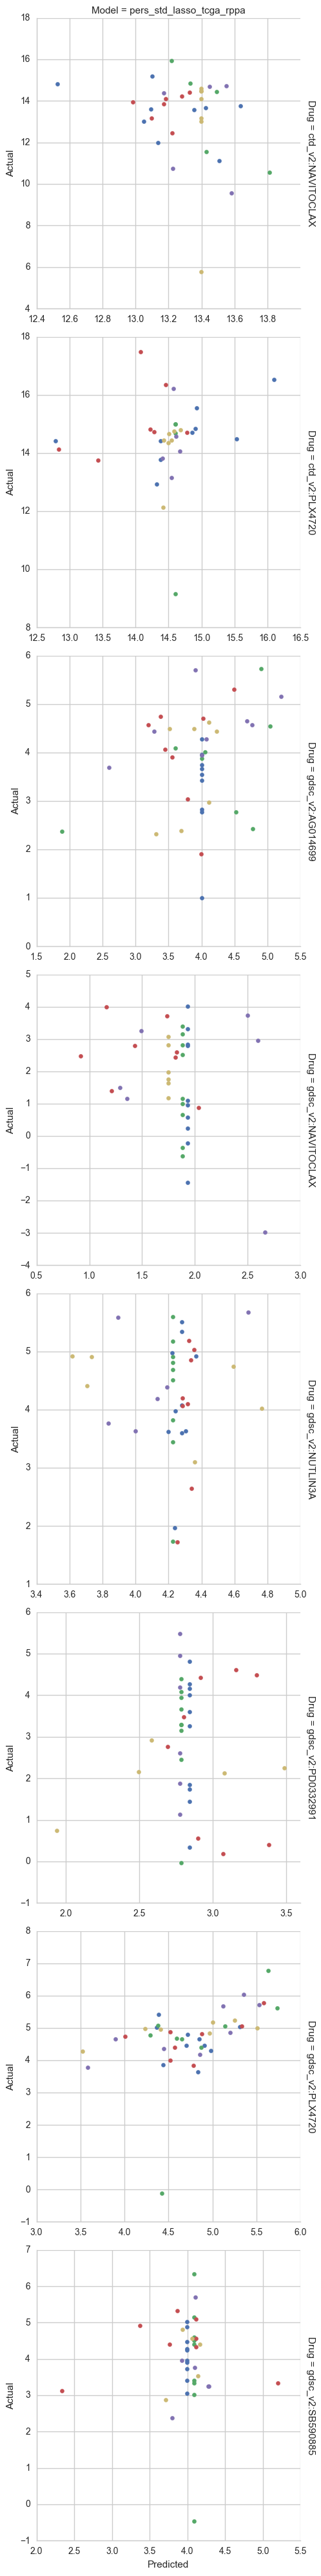

In [49]:
d_plt = d_pred.filter(regex='pers_std_lasso_tcga_rppa|Actual')
grid, d_plt = plot_predictions(d_plt, share_axes=False)

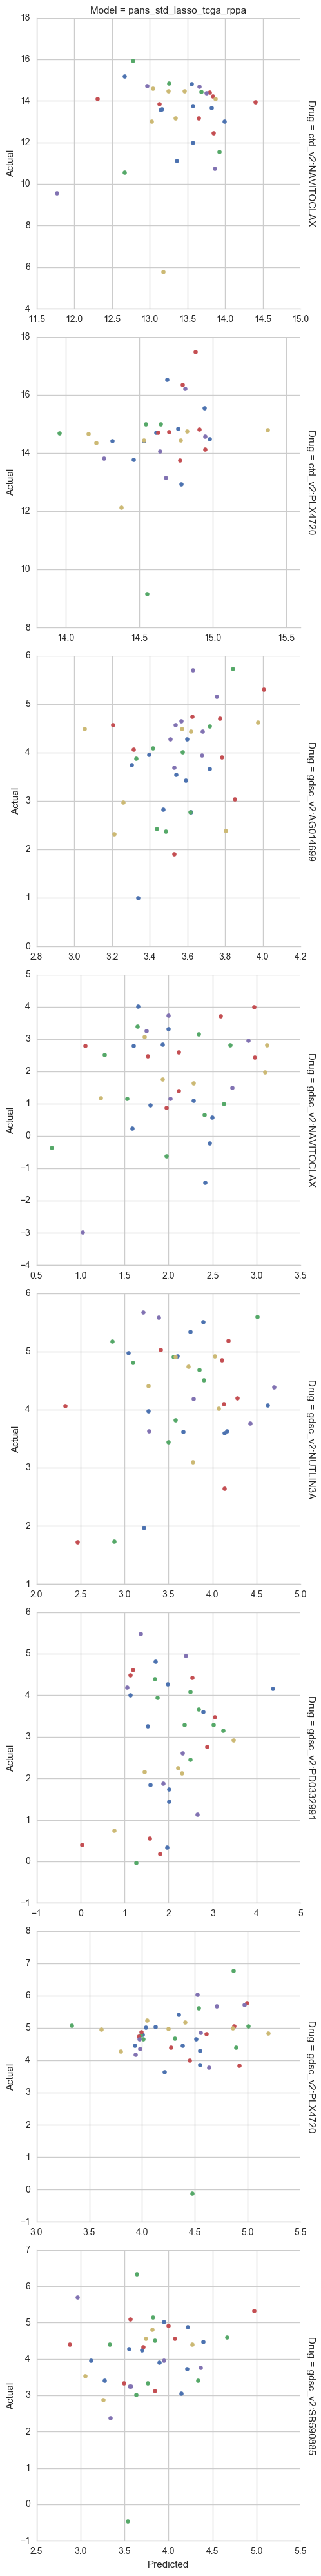

In [172]:
d_plt = d_pred.filter(regex='pans_std_lasso_tcga_rppa|Actual')
grid, d_plt = plot_predictions(d_plt, share_axes=False)
grid.savefig(plot_file('lasso_rppa_pansite.png'))